In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('paper')
import beam.calc.electron as ecalc
from lens import profile
from scipy.optimize import minimize
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
from matplotlib.ticker import FormatStrFormatter

green = '#228833'
purple = '#AA3377'
cyan = '#33BBEE'
red = '#CC3311'
yellow = '#CCBB44'
orange = '#EE7733'
blue = '#0077BB'
magenta = '#EE3377'
# Not from the color palette
grey = '#444444'
denSize = 18
folder = 'Ramp_Paper/'

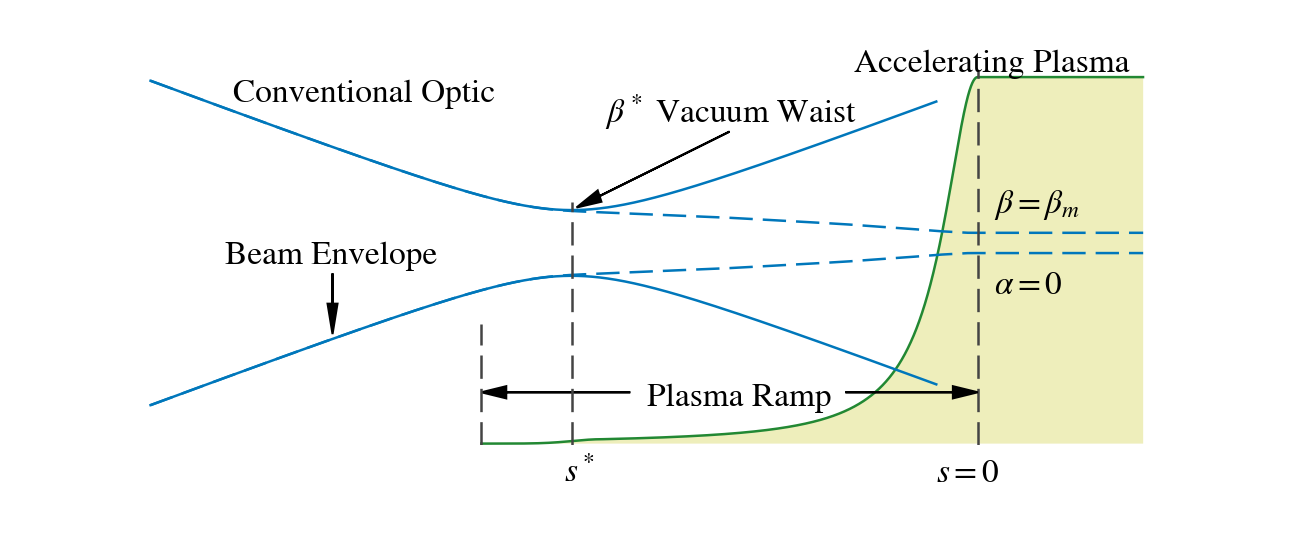

In [2]:
# Now we need the ramp shape plot to set up the entire thing
N = 5000
beta0 = 1.0
alpha0 = 0.0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
z = np.linspace(-20, 100, N)
frac = 1/(1+(a*z)**2)
# Create the perturbative part
sel = frac < 0.012
tran = z[sel][0]
ztran = z[sel]
sigma = 3.5
frac[sel] = frac[sel][0]*np.exp(-(ztran - z[sel][0])**2/(2*sigma**2))
# Create the flattop region
sel = z <= 0
frac[sel] = 1.0
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Incoming free space beam
bs = beta[-1]/(1 + alpha[-1]**2)
ss = 100 + alpha[-1]*bs
betaFree = (z-ss)**2/bs+bs

# From this we need the beam envelope
r = np.sqrt(beta)
rf = np.sqrt(betaFree)

sel = z < 60
plt.figure(figsize=(3.37, 1.5), dpi=300, frameon=False)
plt.plot(z[sel]+40, np.flip(frac[sel], 0), c=green, zorder=1)
plt.fill_between(z, 0.0, np.flip(frac, 0), where=frac>=0.0, facecolor='#EEEEBB', zorder=0)
plt.ylim(-0.005, 1.1)
plt.axis('off')

sel = z < 75
plt.twinx()
plt.plot(z, np.flip(r, 0), '--')
plt.plot(z[sel], np.flip(rf, 0)[sel], c=blue)
plt.plot(z, -np.flip(r, 0), '--',c=blue)
plt.plot(z[sel], -np.flip(rf, 0)[sel], c=blue)
plt.plot([80-ss, 80-ss], [-20, 4], 'k--', c=grey)
plt.plot([80, 80], [-20, 17], 'k--', c=grey)
plt.plot([20, 20], [-20, -8], 'k--', c=grey)
plt.ylim(-20, 20)

plt.text(35, 12, r'$\beta^*$ Vacuum Waist')
plt.text(65, 17, r'Accelerating Plasma')
plt.text(40, -16, 'Plasma Ramp')
plt.arrow(50, 11, -18.5, -7.5, head_width=1.2, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)
#plt.arrow(81, 18, 10, -1.5, head_width=1.2, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)
plt.arrow(38, -14.75, -18, 0, head_width=1.2, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)
plt.arrow(64, -14.75, 16, 0, head_width=1.2, head_length=3, linewidth=0.5, fc='k', length_includes_head=True,
          zorder=10)
plt.text(30, -23.5, r'$s^*$')
plt.text(75, -23.5, r'$s=0$')
plt.text(82, 3, r'$\beta=\beta_m$')
plt.text(82, -5, r'$\alpha=0$')
plt.text(-11, -2, 'Beam Envelope')
plt.arrow(2, -3, 0, -6, head_width=1.2, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)
plt.text(-10, 14, 'Conventional Optic')

plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=1, left=-0.04, right=1.04) 
plt.savefig(folder+'Ramp_Setup.eps')
plt.savefig(folder+'Ramp_Setup.png')
plt.show()

alpha_m= -0.1


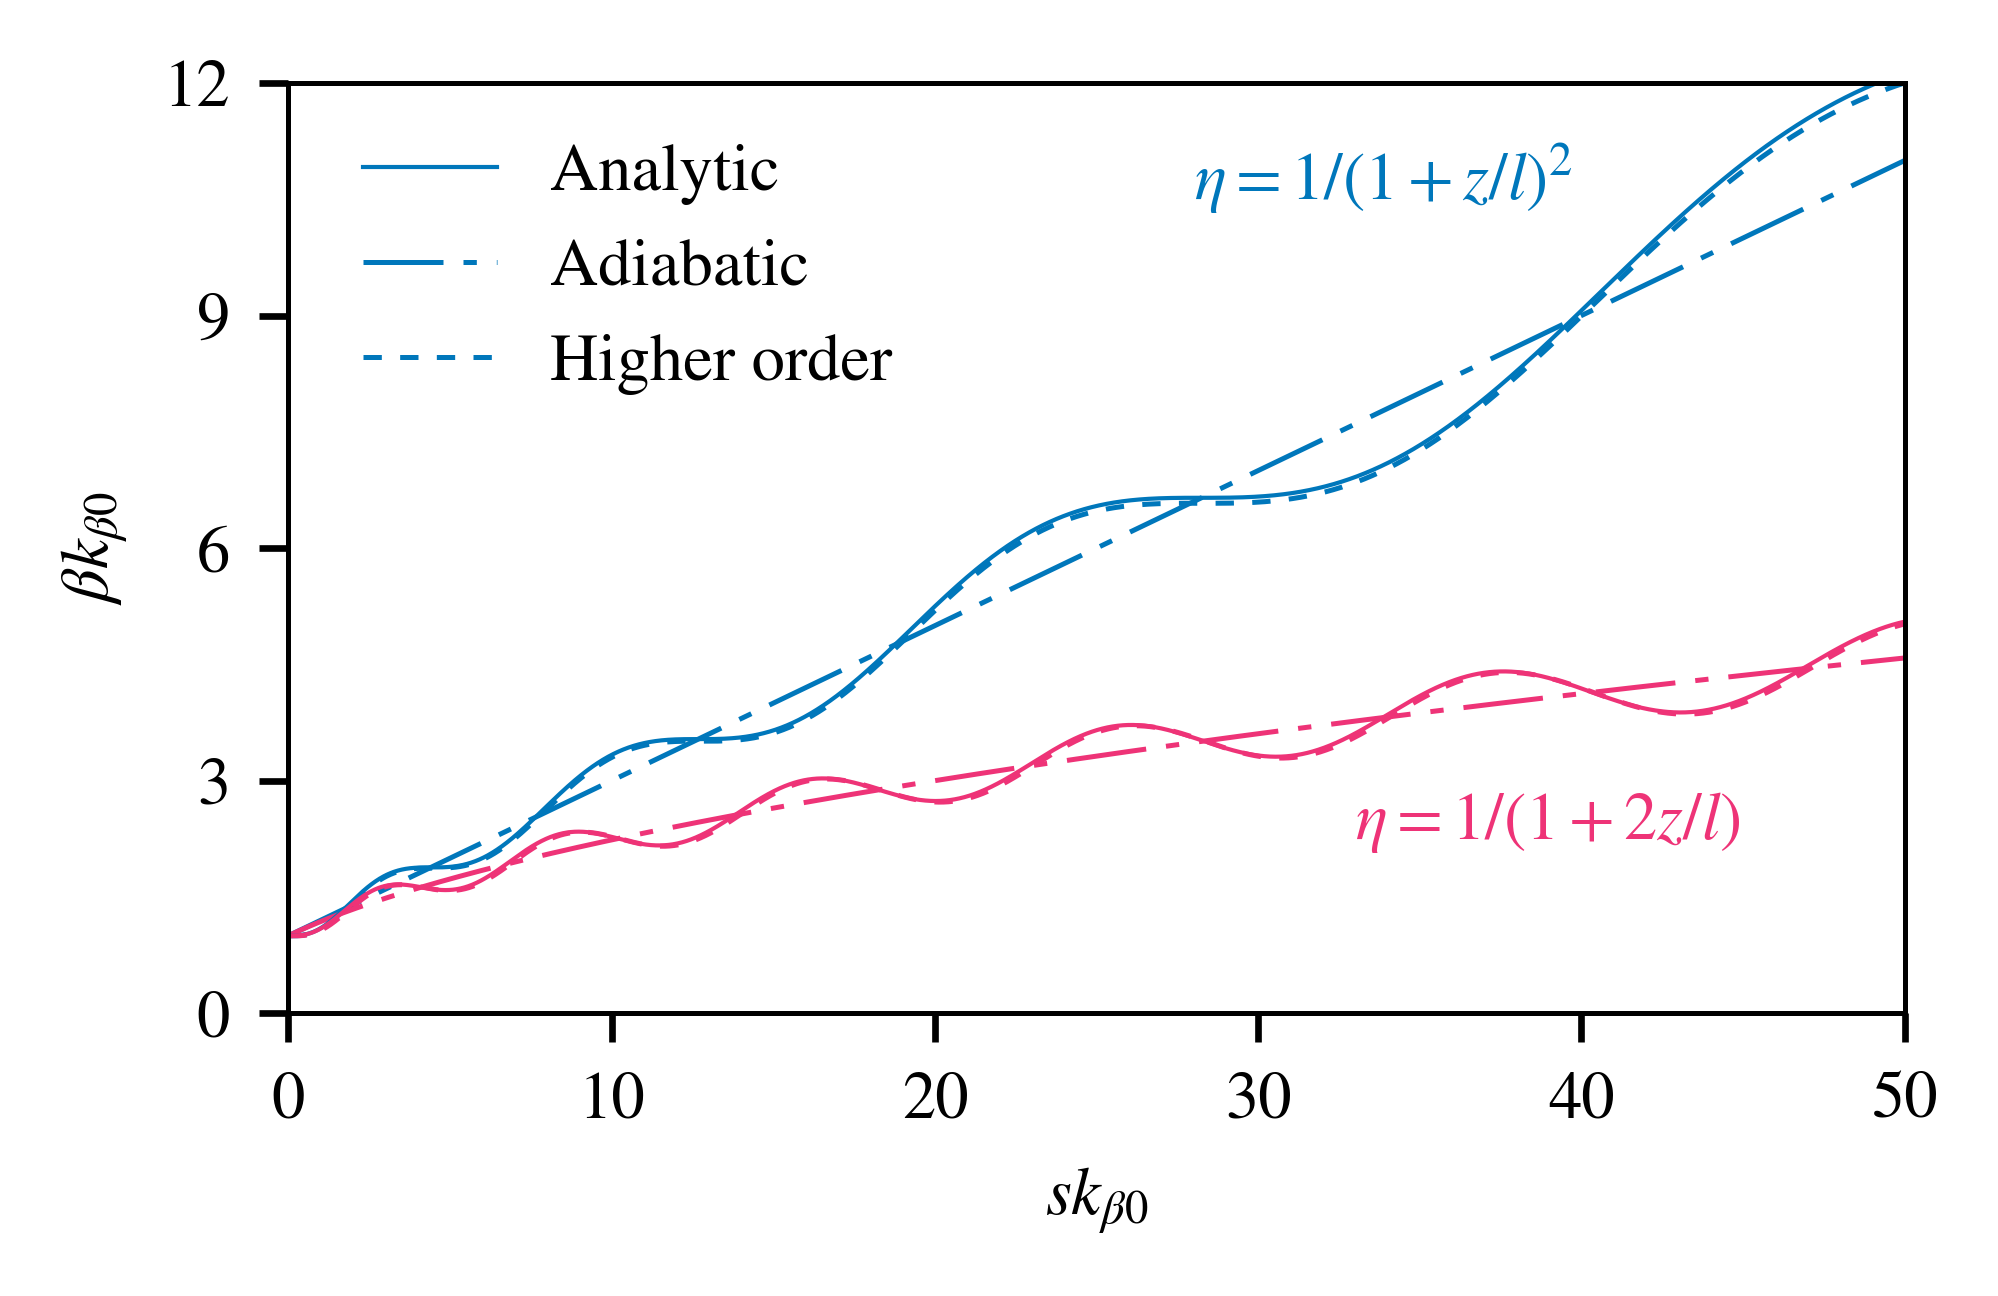

In [3]:
# Higher order adiabatic solution
N = 10000
beta0 = 1
alpha0 = 0
gamma0 = (1+alpha0**2)/beta0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(0, 100, N, retstep=True)

# -------------First ramp shape--------------
betam = 1+a*z
frac = 1/(1+a*z)**2
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Exact solution
c1 = 0.5*(beta0 - (gamma0-2*alpha0*alpham+alpham**2*beta0)/(1-alpham**2))
c2 = (alpha0-alpham*beta0)/np.sqrt(1-alpham**2)
c0 = np.sqrt(c1**2+c2**2+1/(1-alpham**2))
Phi = np.sqrt(1-alpham**2)*np.log(betam)/(2*alpham)
beta_exact = betam*(c0+c1*np.cos(2*Phi)+c2*np.sin(2*Phi))

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Higher order adibatic solution
c0 = 0.5*(beta0+gamma0-2*alpha0*alpham)
c1 = 0.5*(beta0-gamma0+2*alpha0*alpham)
c2 = -alpha0+alpham*beta0
theta = np.cumsum(1/betam)*dz
beta_adi2 = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

fig = plt.figure(figsize=(3.37, 2.2), dpi=600)
ax = plt.subplot(111)
#plt.plot(z, beta)
plt.plot(z, beta_exact, c=blue, linewidth=.5)
plt.plot(z, beta_adi, '-.', c=blue, zorder=1)
plt.plot(z, beta_adi2, ':')
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
plt.text(28, 10.5, r'$\eta=1/(1+z/l)^2$', color=blue)

# -------------Second ramp shape--------------
betam = np.sqrt(1+2*a*z)
frac = 1/(1+2*a*z)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Higher order adibatic solution
c0 = 0.5*(beta0+gamma0-2*alpha0*alpham)
c1 = 0.5*(beta0-gamma0+2*alpha0*alpham)
c2 = -alpha0+alpham*beta0
theta = np.cumsum(1/betam)*dz
beta_adi2 = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

plt.plot(z, beta, c=magenta, linewidth=.5)
plt.plot(z, beta_adi, '-.', c=magenta, zorder=1)
plt.plot(z, beta_adi2, ':', c=magenta)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
plt.text(33, 2.25, r'$\eta=1/(1+2z/l)$', color=magenta)

plt.legend([r'Analytic', r'Adiabatic', r'Higher order'], bbox_to_anchor=(.21, .8), loc='center', frameon=False)
ax.yaxis.set_ticks(np.linspace(0, 12, 5))
plt.ylim(0, 12)
plt.xlim(0, 50)
plt.tight_layout()
plt.savefig(folder+'Adiabatic_Theory.eps')
plt.savefig(folder+'Adiabatic_Theory.png')
plt.show()

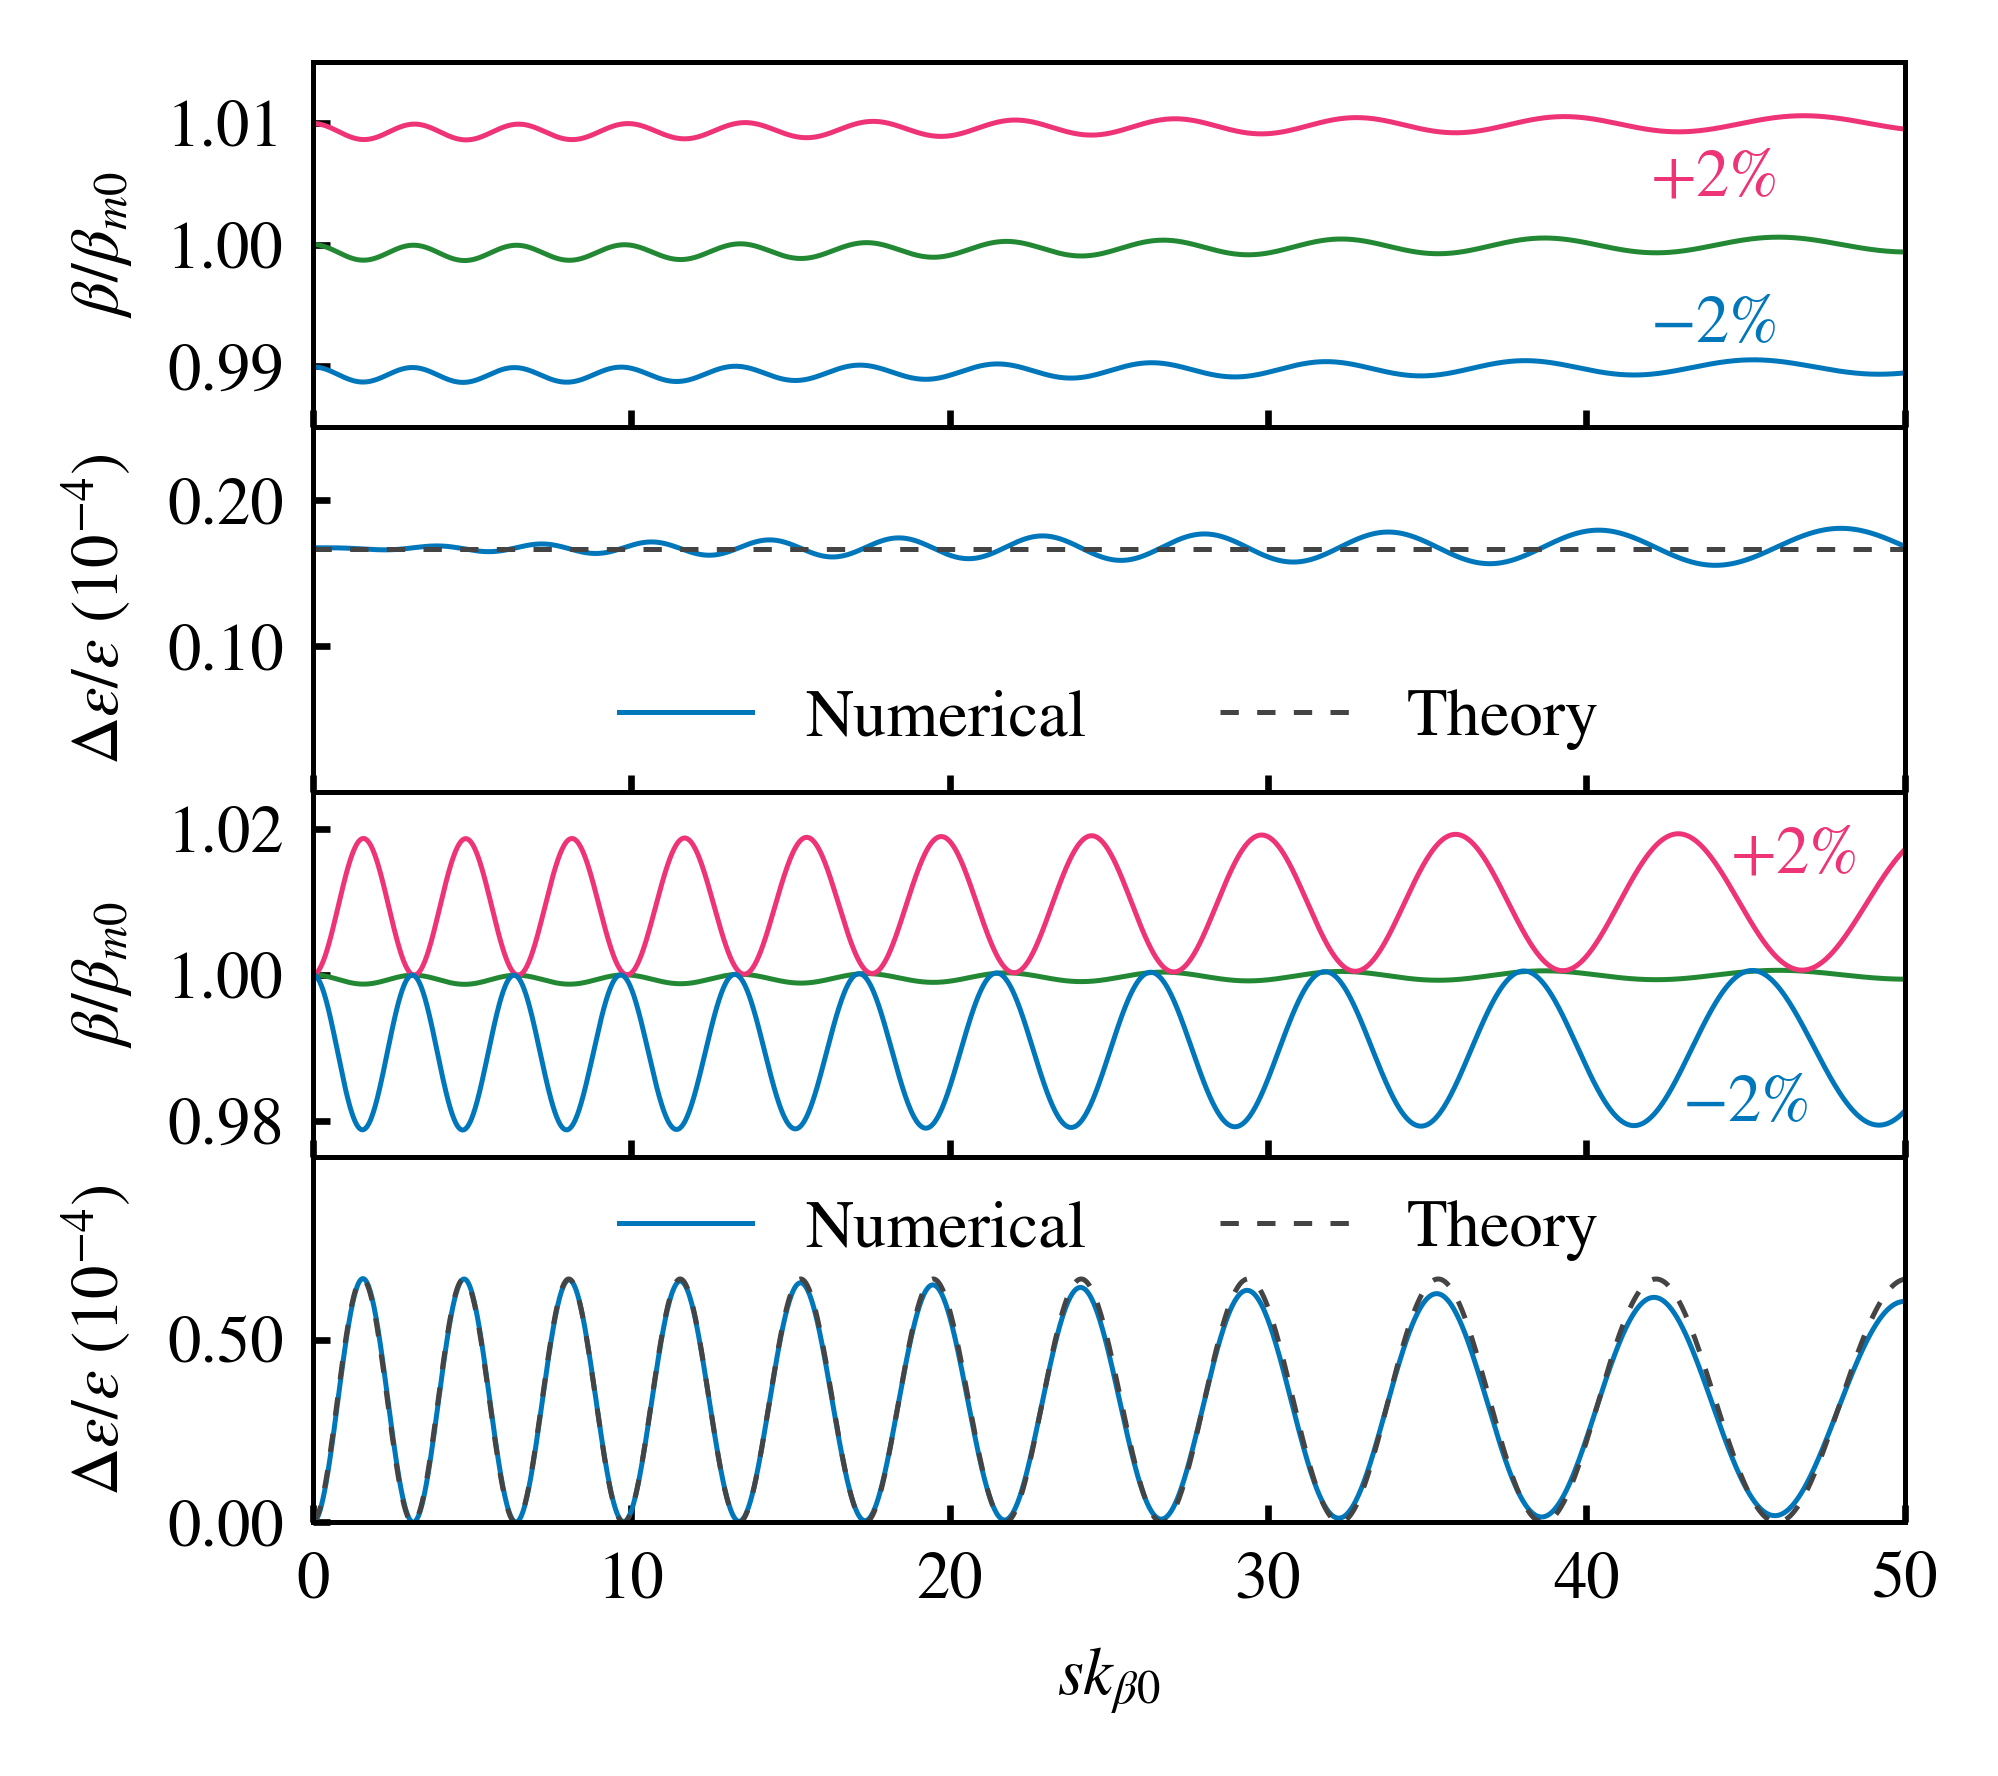

In [4]:
# Comparisons of beam evolution and emittance growth
# The complicated emittance growth and chromatic beam evolution plot
# Try setting a=0.2 and beta0=0.99 - oscillations of centroid energy go away
# Matches the prediction for the small correction to beta_m0 for being perfectly 
N = 5000
beta0 = 1.0
#beta0 = 1.0-.01
alpha0 = 0
gb0 = 20000
delta = 0.02
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.05
#a = .2
alpham = -a/2
z, dz = np.linspace(0, 100, N, retstep=True)
frac = 1/(1+(a*z)**2)
ne = frac*ne0
#Plot 1 beams all start matched
#-----------------------------------------------------------------------------------------
betam = 1/np.sqrt(frac)
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1+delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*np.sqrt(1-delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*np.sqrt(1+deltaA[i]),
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
    
# Plotting
fig = plt.figure(figsize=(3.37, 3), dpi=600)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam, color=green)
ax1.plot(z, beta1/betam, color=magenta)
ax1.plot(z, betan1/betam, color=blue)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
plt.ylabel(r'$\beta/\beta_{m0}$')
ax1.yaxis.set_ticks([0.99, 1.0, 1.01])
plt.ylim(0.985, 1.015)
plt.text(42, 1.004, r'$+2\%$', color=magenta)
plt.text(42, 0.992, r'$-2\%$', color=blue)
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*1e4)
ax2.plot([0, 100], [delta**2/24*1e4, delta**2/24*1e4], ':', c=grey)
#ax2.plot([0, 100], [delta**2/24-alpham**4/8, delta**2/24-alpham**4/8], '--', c=grey)
plt.ylim(0, .25)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ ($10^{-4}$)')
ax2.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
ax2.yaxis.set_ticks([0.1, 0.2])
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend(['Numerical', 'Theory'], bbox_to_anchor=(.5, .2), loc='center', frameon=False, ncol=2)

# Plot 2 beams all start with the same initial conditions
#-----------------------------------------------------------------------------------------
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0*(1-delta), dgdz0, ne0)

for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0,
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(1/betam)*dz

# Plotting
ax3 = plt.subplot(gs[2, 0], sharex=ax1)
ax3.plot(z, beta/betam, color=green)
ax3.plot(z, beta1/betam, color=magenta)
ax3.plot(z, betan1/betam, color=blue)
plt.ylabel(r'$\beta/\beta_{m0}$')
ax3.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
ax3.yaxis.set_ticks([0.98, 1.0, 1.02])
plt.ylim(0.975, 1.025)
plt.text(44.5, 1.014, r'$+2\%$', color=magenta)
plt.text(43, 0.98, r'$-2\%$', color=blue)

ax4 = plt.subplot(gs[3, 0], sharex=ax1)
ax4.plot(z, (eps-1)*1e4)
ax4.plot(z, (1-np.cos(2*theta))*delta**2/12*1e4, ':', c=grey)
#plt.ylim(0, 1.5e-4)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ ($10^{-4}$)')
ax4.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.yaxis.set_ticks([0.00, 0.5])
plt.legend(['Numerical', 'Theory'], bbox_to_anchor=(.5, .8), loc='center', frameon=False, ncol=2)
plt.ylim(0, 1)
plt.xlim(0, 50)
plt.xlabel(r'$s k_{\beta0}$')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.savefig(folder+'Adiabatic_Emittance.eps')
plt.savefig(folder+'Adiabatic_Emittance.png')
plt.show()

alpha_m= -0.5
28.9303930393
alpha_m= -0.1
152.230223022


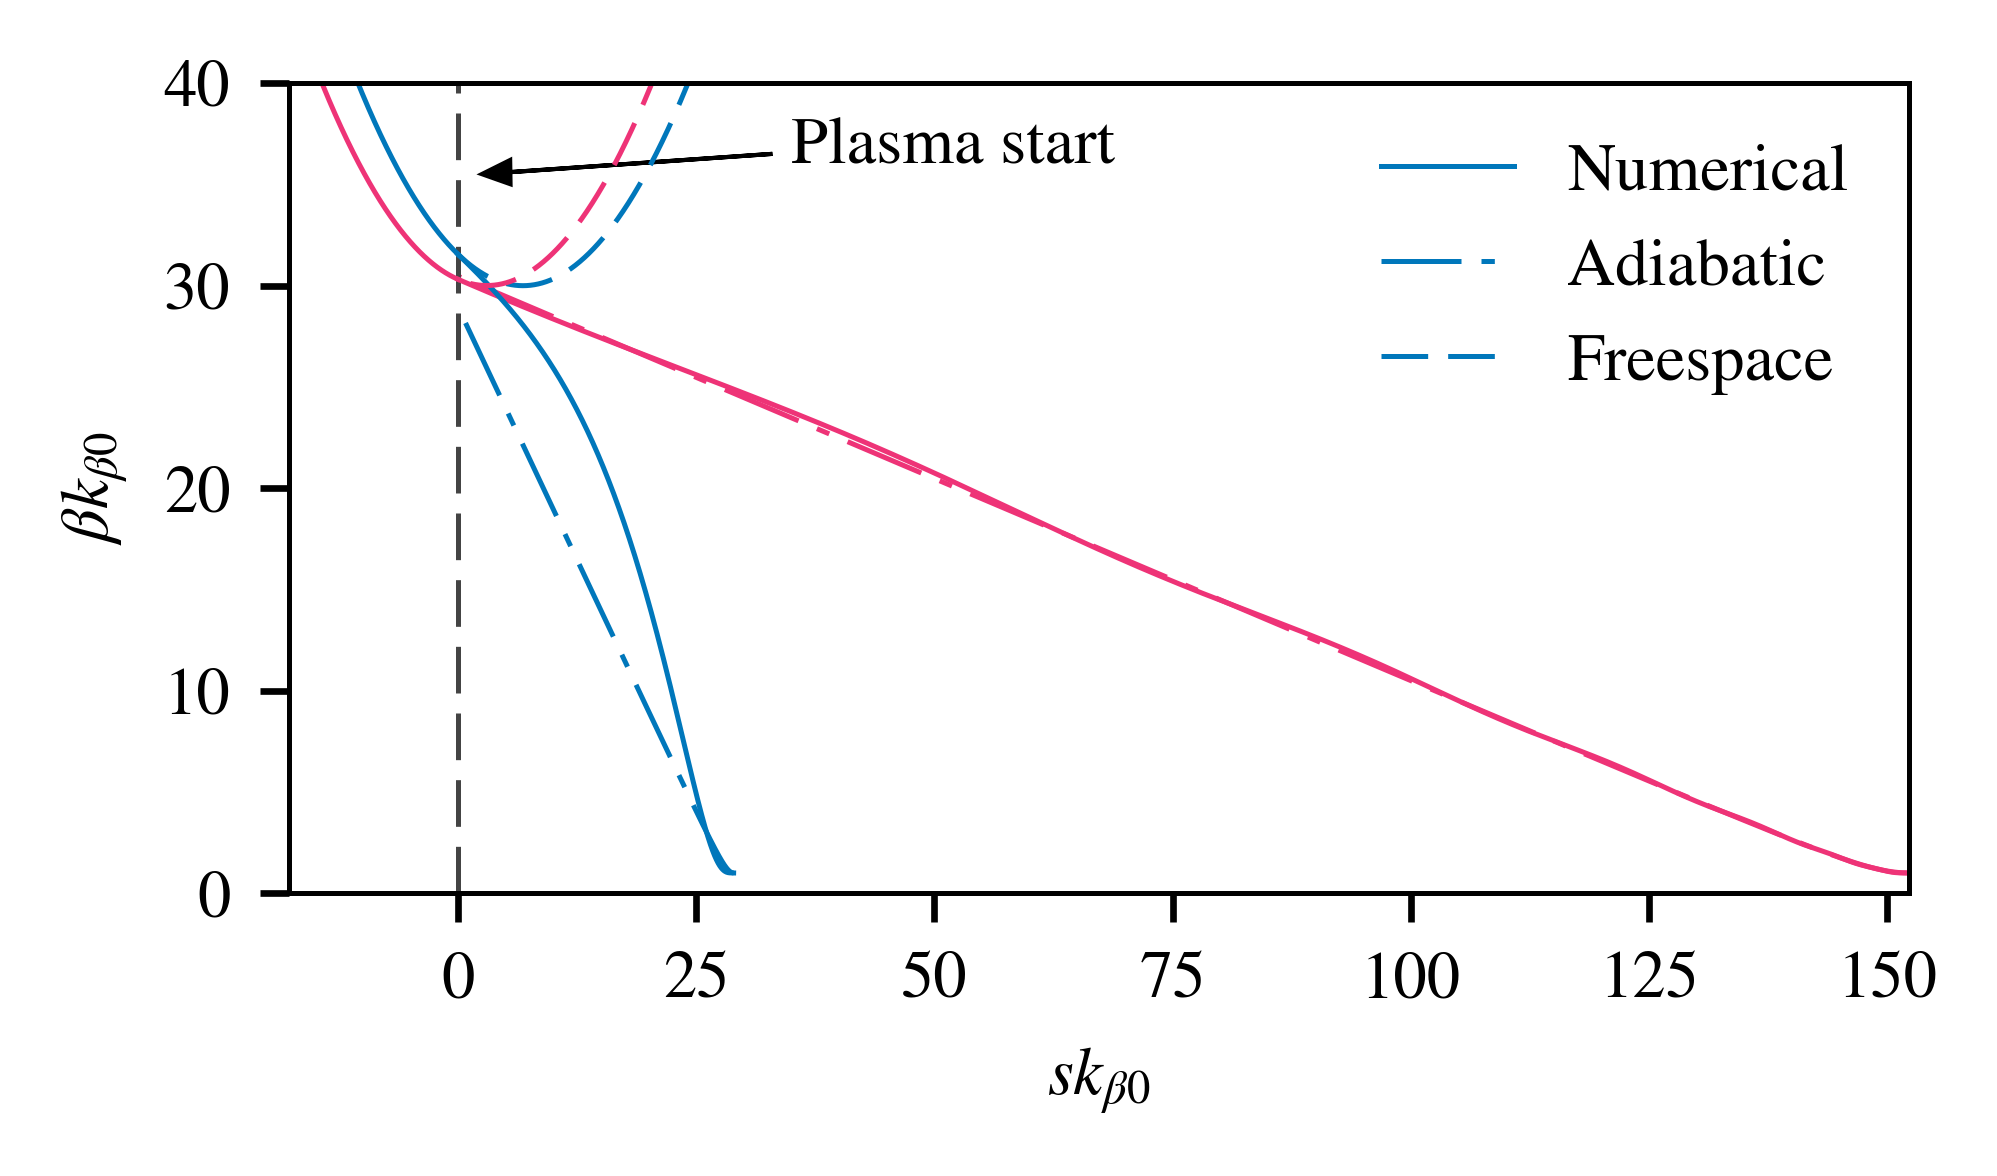

In [5]:
# Non adiabatic ramp figure - difficult to actually make non-adiabatic ramps
N = 10000
Zmax = 175
beta0 = 1
alpha0 = 0
gamma0 = (1+alpha0**2)/beta0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 1.0
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(0, Zmax, N, retstep=True)
frac = 1/(1+(a*z)**2)
betam = 1/np.sqrt(frac)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Waist size along the ramp
betas = 1/np.array(gamma)
sel = betas < 30
sel2 = betas >= 30
tranz = z[sel]
tran = tranz[-1]
print(tran)
bs = betas[sel][-1]
ss = tran+np.array(alpha)[sel][-1]*bs
betaFree = (z-ss)**2/bs+bs

zp = np.linspace(tran, -Zmax+tran, N)
fig = plt.figure(figsize=(3.37, 2), dpi=600)
ax = plt.subplot(111)
plt.plot(zp[sel], np.array(beta)[sel], label='Numerical')
plt.plot(zp[sel], beta_adi[sel], '-.', c=blue, zorder=1, label='Adiabatic')
plt.plot(zp[sel], betaFree[sel], '--', c=blue, label='Freespace')
plt.plot(zp[sel2], betaFree[sel2], c=blue)
#plt.plot([ss-tran, ss-tran], [0, 50], '--', c=grey, zorder=0, label=None)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')

#--------------------------------------------
# Adiabatic ramp with the same beam expansion
a = 0.2
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(0, Zmax, N, retstep=True)
frac = 1/(1+(a*z)**2)
betam = 1/np.sqrt(frac)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Waist size along the ramp
betas = 1/np.array(gamma)
sel = betas < 30
sel2 = betas >= 30
tranz = z[sel]
tran = tranz[-1]
print(tran)
bs = betas[sel][-1]
ss = tran+np.array(alpha)[sel][-1]*bs
betaFree = (z-ss)**2/bs+bs

zp = np.linspace(tran, -Zmax+tran, N)
plt.plot(zp[sel], np.array(beta)[sel], c= magenta,zorder=1)
plt.plot(zp[sel], beta_adi[sel], '-.', c=magenta, zorder=0)
plt.plot(zp[sel], betaFree[sel], '--', c=magenta)
plt.plot(zp[sel2], betaFree[sel2], c=magenta)
plt.plot([0, 0], [0, 50], '--', c=grey, zorder=0, label=None)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
plt.text(35, 36, 'Plasma start')
plt.arrow(33, 36.5, -30.5, -1, head_width=1.2, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)
plt.legend(frameon=False)

plt.ylim(0, 40)
plt.xlim(-Zmax+tran+5, tran)

plt.tight_layout()
plt.savefig(folder+'Non-adiabatic.eps')
plt.savefig(folder+'Non-adiabatic.png')
plt.show()

alpha_m= -0.5
28.9303930393
alpha_m= -0.1
152.230223022


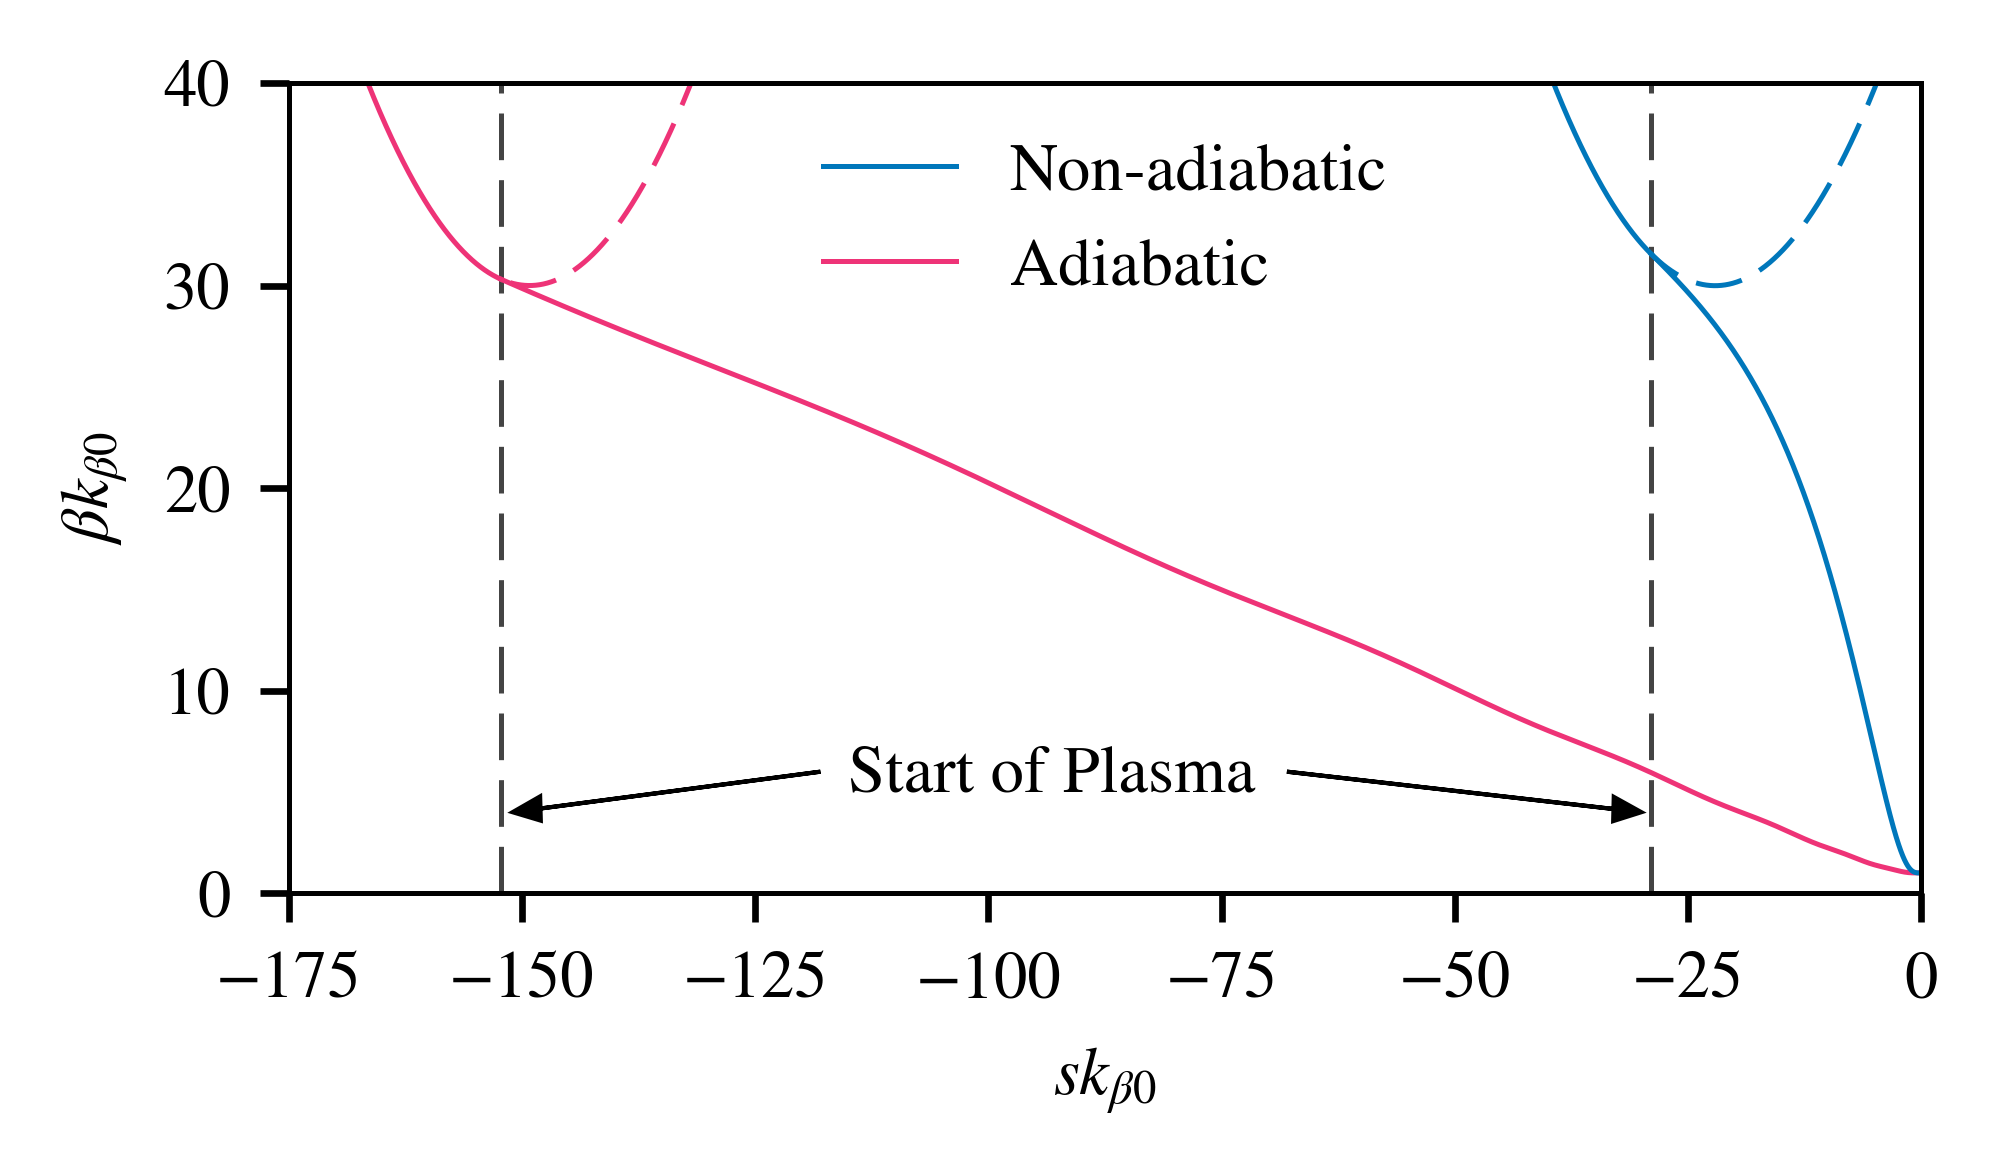

In [6]:
# Second version with the ramps ending at the same place
# Non adiabatic ramp figure - difficult to actually make non-adiabatic ramps
N = 10000
Zmax = 175
beta0 = 1
alpha0 = 0
gamma0 = (1+alpha0**2)/beta0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 1.0
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(0, Zmax, N, retstep=True)
frac = 1/(1+(a*z)**2)
betam = 1/np.sqrt(frac)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Waist size along the ramp
betas = 1/np.array(gamma)
sel = betas < 30
sel2 = betas >= 30
tranz = z[sel]
tran = tranz[-1]
print(tran)
bs = betas[sel][-1]
ss = tran+np.array(alpha)[sel][-1]*bs
betaFree = (z-ss)**2/bs+bs

zp = np.linspace(0, -Zmax, N)
fig = plt.figure(figsize=(3.37, 2), dpi=600)
ax = plt.subplot(111)
plt.plot(zp[sel], np.array(beta)[sel], label='Non-adiabatic')
plt.plot(zp[sel], betaFree[sel], '--', c=blue)
plt.plot(zp[sel2], betaFree[sel2], c=blue)
plt.plot([-tran, -tran], [0, 50], '--', c=grey, zorder=0, label=None)
#plt.plot([ss-tran, ss-tran], [0, 50], '--', c=grey, zorder=0, label=None)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')

#--------------------------------------------
# Adiabatic ramp with the same beam expansion
a = 0.2
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(0, Zmax, N, retstep=True)
frac = 1/(1+(a*z)**2)
betam = 1/np.sqrt(frac)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Waist size along the ramp
betas = 1/np.array(gamma)
sel = betas < 30
sel2 = betas >= 30
tranz = z[sel]
tran = tranz[-1]
print(tran)
bs = betas[sel][-1]
ss = tran+np.array(alpha)[sel][-1]*bs
betaFree = (z-ss)**2/bs+bs

#zp = np.linspace(tran, -Zmax+tran, N)
plt.plot(zp[sel], np.array(beta)[sel], c= magenta,zorder=1, label='Adiabatic')
plt.plot(zp[sel], betaFree[sel], '--', c=magenta)
plt.plot(zp[sel2], betaFree[sel2], c=magenta)
plt.plot([-tran, -tran], [0, 50], '--', c=grey, zorder=0, label=None)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
plt.arrow(33, 36.5, -30.5, -1, head_width=1)
plt.legend(frameon=False)

plt.text(-115, 5, 'Start of Plasma')
plt.arrow(-118, 6, -33, -2, head_width=1.2, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)
plt.arrow(-68, 6, 38, -2, head_width=1.2, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)

plt.ylim(0, 40)
plt.xlim(-Zmax, 0)

plt.tight_layout()
plt.savefig(folder+'Non-adiabatic.eps')
plt.savefig(folder+'Non-adiabatic.png')
plt.show()

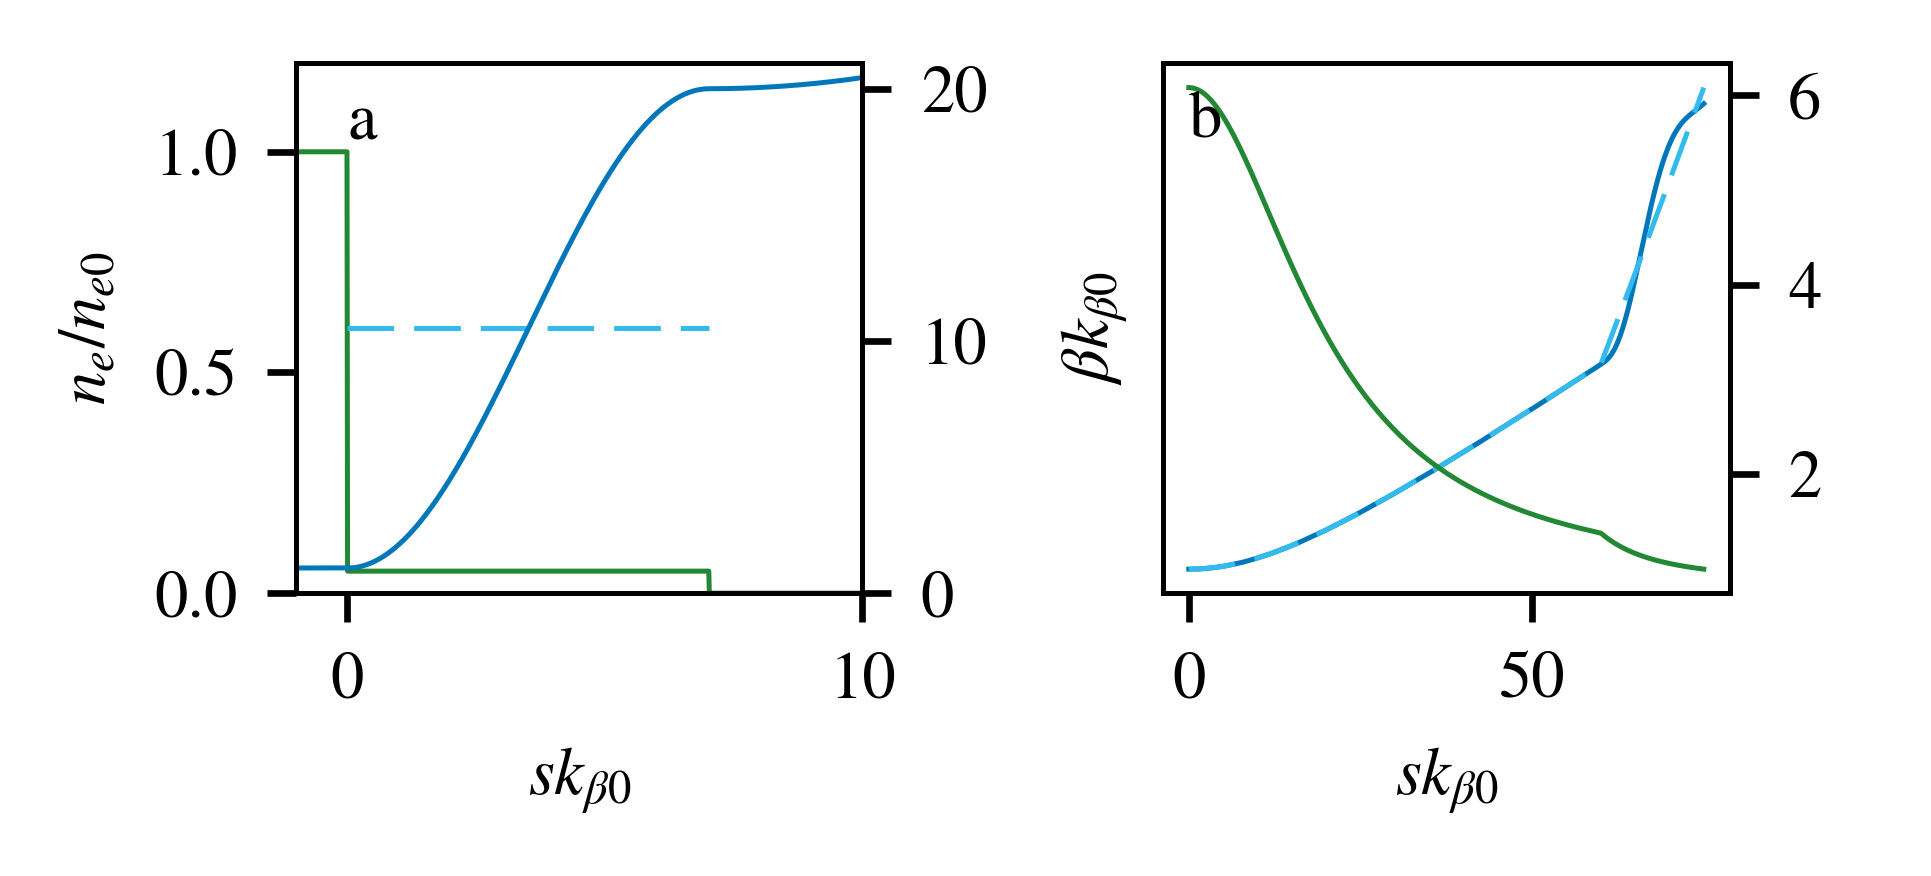

In [7]:
# Figure with kinked ramps and box ramp
# Lets plot some example square ramps
theta = lambda s: 2*np.sqrt(eta)*s
betaA = lambda s: np.real((B0/2-(a0**2+1)/eta/B0/2+1j*a0/np.sqrt(eta))*np.exp(1j*theta(s))
                          + (B0/2+(a0**2+1)/eta/B0/2))
betaD = lambda s: B0+s**2/B0

N = 1000
B0 = 20
a0 = 0
eta = 0.05
L = np.pi/(2*np.sqrt(eta))
s = np.linspace(-1, 10, N)
sel = [s > L, (s <= L) & (s > 0), s <= 0]
ne = np.piecewise(s, sel, [0, eta, 1.0])
beta = np.zeros(N)
beta[sel[0]] = betaD(s[sel[0]]-L)
beta[sel[1]] = betaA(s[sel[1]]+L)
beta[sel[2]] = 1.0
center = (B0/2+(a0**2+1)/eta/B0/2)

plt.figure(figsize=(3.37, 1.5), dpi=600)
plt.subplot(121)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$n_{e}/n_{e0}$')

plt.plot(s, ne, c=green)
plt.ylim(0, 1.2)
ax1 = plt.twinx()
plt.plot(s, beta)
plt.plot([0, L], [center, center], 'k--', c=cyan, zorder=1)
#ax1.yaxis.tick_left()
#ax1.set_axis_off()
plt.ylim(0.0, 21)
plt.xlim(-1, 10)
plt.text(0, 18, 'a')
#plt.legend([r'$\beta$', r'$\beta_m$'], bbox_to_anchor=(0.85, 0.5), loc='center', frameon=False)

#--------------------------------------------------
# Kink in the plasma density
N = 10000
Zmax = 75
beta0 = 1
alpha0 = 0
gamma0 = (1+alpha0**2)/beta0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
# Create the plasma density
z, dz = np.linspace(0, Zmax, N, retstep=True)

L = 60
a1 = 0.05
a2 = 0.2
sel = [z > L, (z <= L) & (z > 0), z <= 0]
frac = np.piecewise(z, sel, [1/(1+(a2*(z[sel[0]]-L*(1-a1/a2)))**2), 1/(1+(a1*z[sel[1]])**2), 1.0])
betam = 1/np.sqrt(frac)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)


ax0 = plt.subplot(122)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')

plt.plot(z, beta)
plt.plot(z, betam, 'k--', c=cyan, zorder=10)
ax1 = plt.twinx()
plt.plot(z, frac, c=green)
ax1.set_axis_off()
#plt.ylim(0.0, 21)
#plt.xlim(-1, 10)
ax0.yaxis.tick_right()
plt.text(0, 0.9, 'b')

plt.tight_layout()
plt.savefig(folder+'Box_Ramp.eps')
plt.savefig(folder+'Box_Ramp.png')
plt.show()

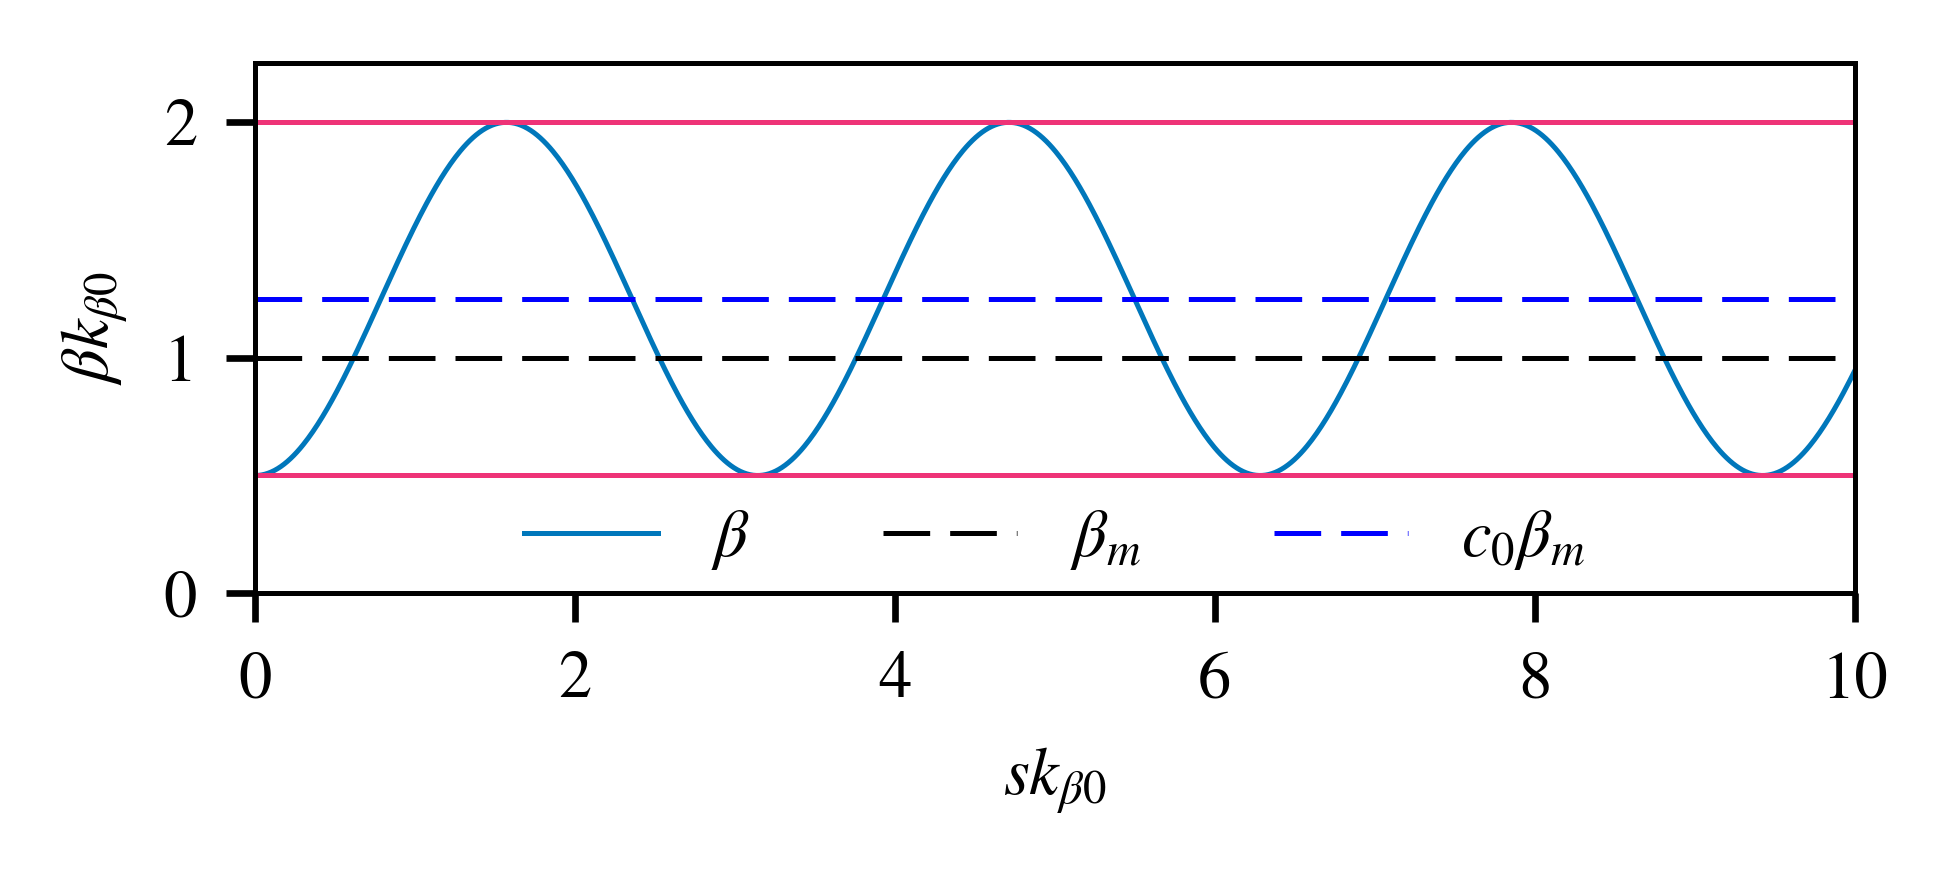

In [8]:
# Uniform plasma evolution example
N = 1000
beta0 = 0.5
alpha0 = 0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 24
z = np.linspace(0, 10, N)
frac = np.ones(N)
ne = frac*ne0
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, 0, ne0)

Bmatched = 1
center = (beta0+1/beta0)/2
A = (beta0-1/beta0)/2

plt.figure(figsize=(3.37,1.5), dpi=600)
plt.plot(z, beta, color=blue)
plt.plot([0.0, 10], [Bmatched, Bmatched], 'k--')
plt.plot([0.0, 10], [center, center], 'b--')
plt.plot([0.0, 10], [center+A, center+A], '-', color=magenta)
plt.plot([0.0, 10], [center-A, center-A], '-', color=magenta)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
plt.legend([r'$\beta$', r'$\beta_m$', r'$c_0\beta_m$'], ncol=3, frameon=False, 
           bbox_to_anchor=(0.5, 0.1), loc='center',)
plt.ylim(0, 2.25)
plt.xlim(0, 10)
plt.tight_layout()
plt.savefig(folder+'Uniform_Evolution.eps')
plt.savefig(folder+'Uniform_Evolution.png')
plt.show()

I0 0.00325570179691
I1 0.0180163344949
I2 0.191682317133


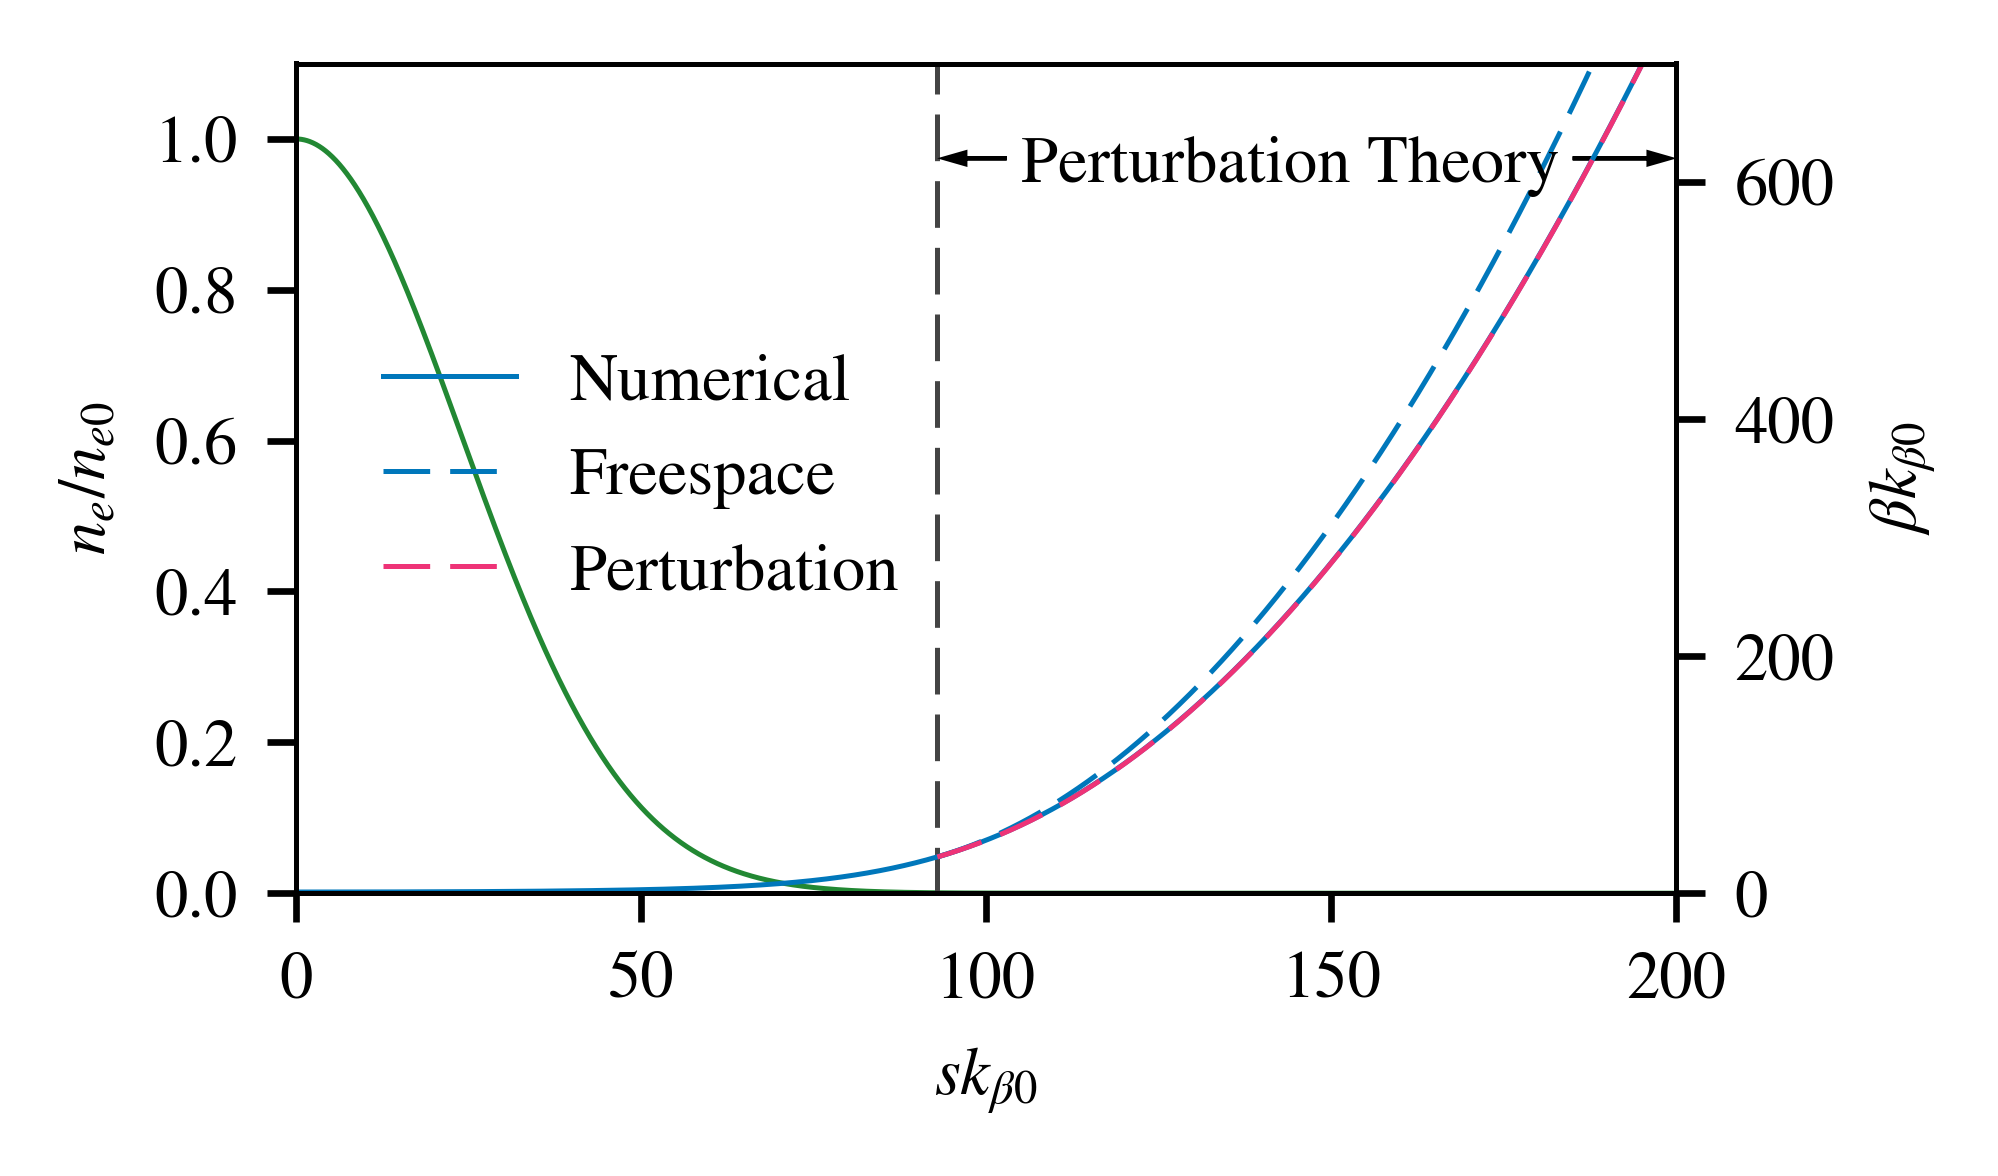

In [9]:
# Perturbative plasma ramp
N = 3500
beta0 = 1
alpha0 = 0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 24
z = np.linspace(0, 200, N)
frac = np.exp(-z**2/(2*a**2))
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

cutoff = .85

zTran = z[-np.array(alpha)>cutoff]
fracTran = frac[-np.array(alpha)>cutoff]
neTran = np.zeros(len(zTran))
tran1 = z[-np.array(alpha)<=cutoff][-1]
betaTran = np.array(beta)[-np.array(alpha)<=cutoff][-1]
alphaTran = np.array(alpha)[-np.array(alpha)<=cutoff][-1]
zint = zTran-zTran[0]
dz = zint[1]-zint[0]
I0 = np.cumsum(fracTran)*dz
I1 = np.cumsum(zint*fracTran)*dz
I2 = np.cumsum(zint*zint*fracTran)*dz
print('I0', I0[-1])
print('I1', I1[-1])
print('I2', I2[-1])
gammaTran = (1+alphaTran**2)/betaTran
betas = 1/(gammaTran+2*(alphaTran*I0[-1]-gammaTran*I1[-1]))
M11 = 1-I0*zint+I1
M12 = zint-I1*zint+I2
betaPer = M11**2*betaTran - 2*M11*M12*alphaTran + M12**2*gammaTran


beta2, alpha2, gamma2, gb2 = ecalc.cs_propagation(zTran, neTran, betaTran, alphaTran, gb0, dgdz0, ne0)

plt.figure(figsize=(3.37, 2), dpi=600)
plt.plot(z, frac, c=green)
#plt.plot(z, z*np.exp(z**2/(4*a**2))/a**2, 'c')
#plt.yscale('log')
plt.ylim(0, 1.1)
plt.ylabel(r'$n_{e}/n_{e0}$')
plt.xlabel(r'$s k_{\beta0}$')
plt.twinx()
plt.plot(z, beta)
plt.plot(zTran, beta2, '--', color=blue)
plt.plot(zTran, betaPer, '--', c=magenta)
plt.plot([tran1, tran1], [-1, 1000], 'k--', c=grey, zorder=0)
plt.ylabel(r'$\beta k_{\beta0}$')
plt.legend([r'Numerical', 'Freespace', 'Perturbation'], bbox_to_anchor=(0.25, 0.5), loc='center', frameon=False)
plt.ylim(0, 700)
plt.xlim(0, 200)
plt.text(105, 600, 'Perturbation Theory')
plt.arrow(103, 620, -9, 0, head_width=10, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)
plt.arrow(185, 620, 14, 0, head_width=10, head_length=3, linewidth=0.5, fc='k', length_includes_head=True)
plt.tight_layout()
plt.savefig(folder+'Perturbed_Evolution.eps')
plt.savefig(folder+'Perturbed_Evolution.png')
plt.show()

z0: 45.3745374537
ne0: 0.011997032515
bs: 10.001184987504237
ss: 47.70412127724946


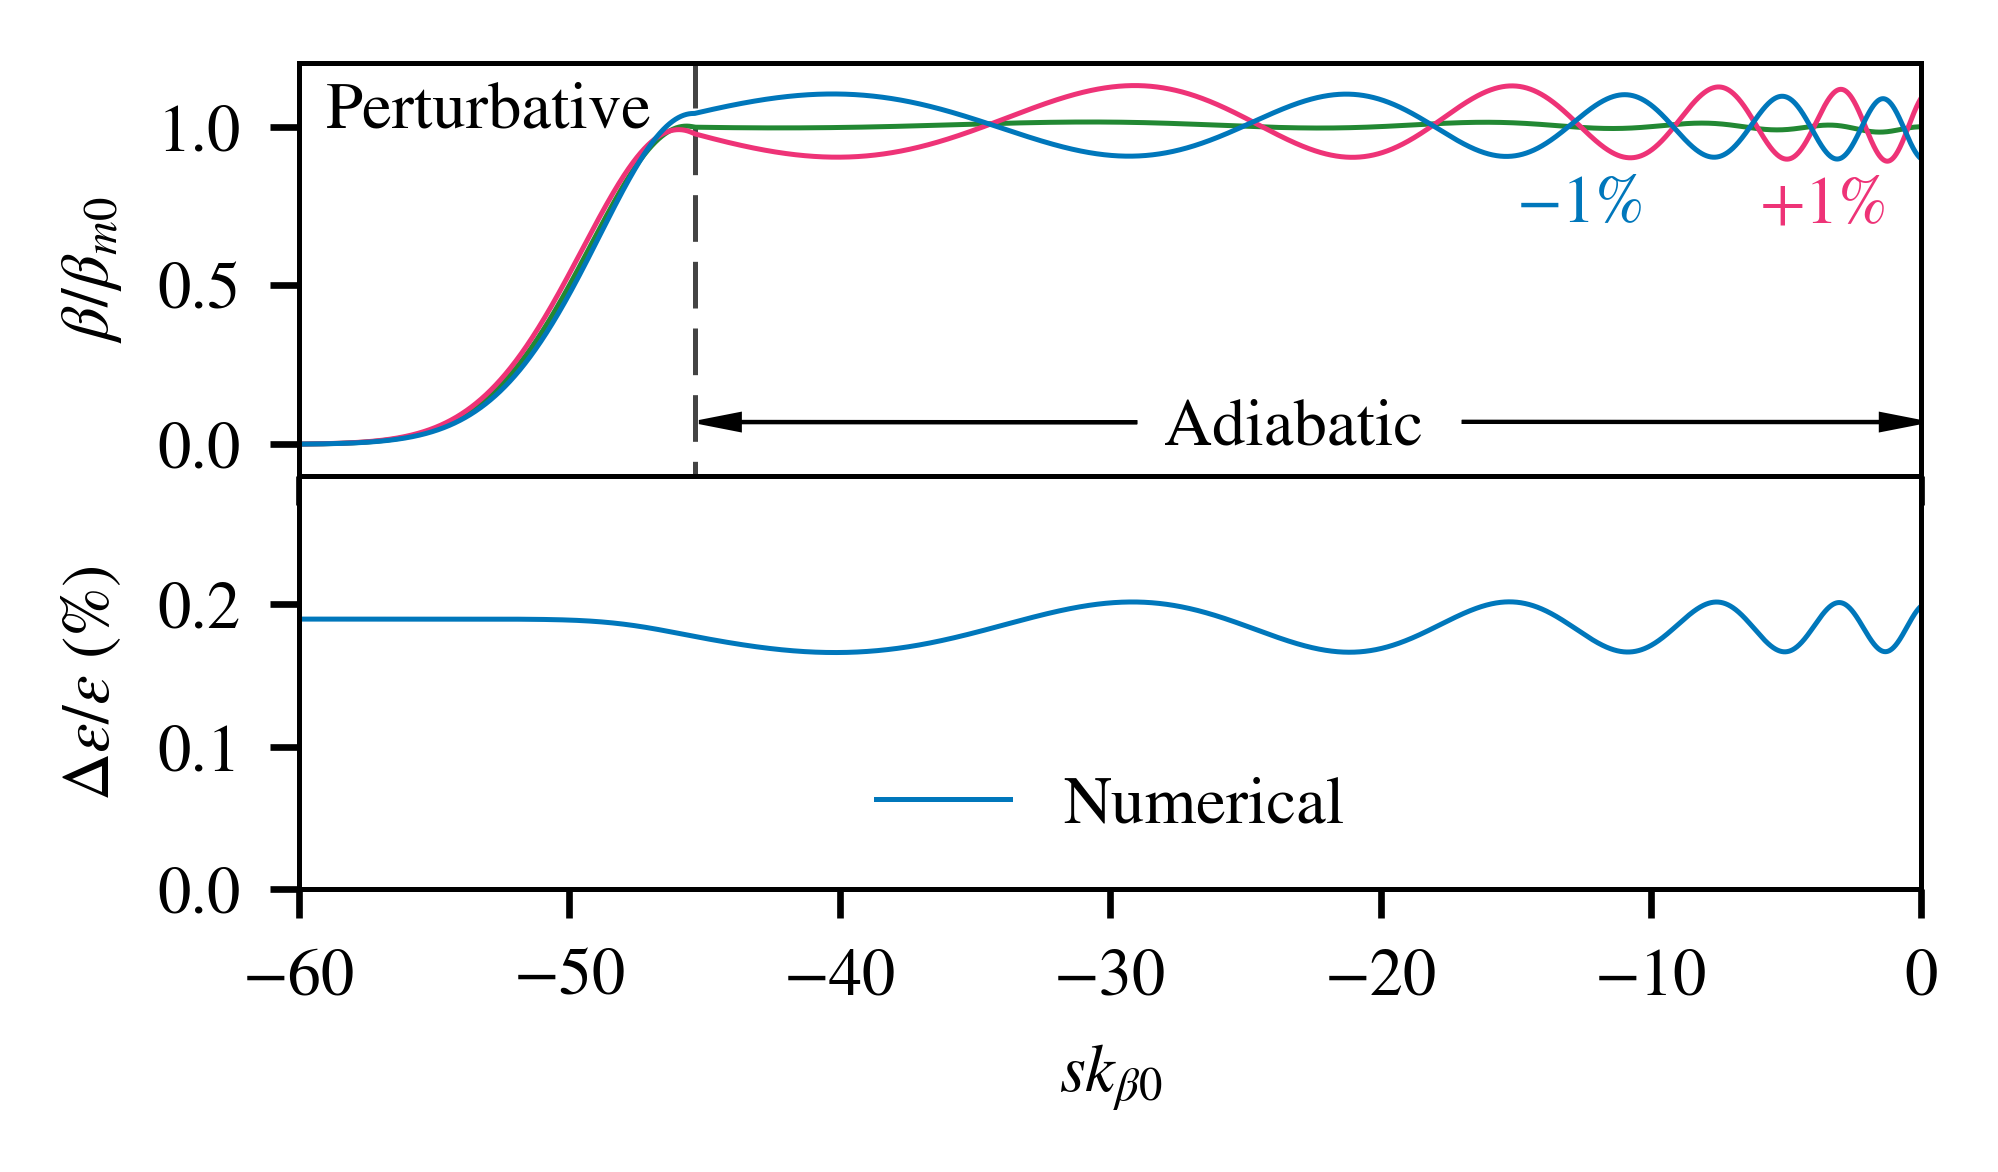

In [10]:
# Beam evolution and emittance growth in a pwfa
# Designer ramp
N = 10000
beta0 = 1.0
alpha0 = 0.0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
z = np.linspace(0, 100, N)
frac = 1/(1+(a*z)**2)
sel = frac < 0.012
tran = z[sel][0]
print('z0:', tran)
print('ne0:', frac[sel][0])
ztran = z[sel]
sigma = 2.541
frac[sel] = frac[sel][0]*np.exp(-(ztran - z[sel][0])**2/(2*sigma**2))
ne = frac*ne0
# Forward propagate to make sure the output is what we expect it to be 
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Calculate free space propagation
bs = 1/gamma[-1]
ss = alpha[-1]*bs + 100
betaFree = (z-ss)**2/bs+bs
print('bs:', bs)
print('ss:', ss)

#------------------------------------------
# Create the up ramp and handle the chromatic input beam to see how everything works
Zmin = -100
bs0 = 10
delta = 0.01
r = 2
z = np.linspace(Zmin, 0, N)
beta0 = (Zmin+ss)**2/bs0+bs0
alpha0 = -(Zmin+ss)/bs0
frac = np.flip(frac, 0)
ne = frac*ne0
betam = 1/np.sqrt(frac)
# propagate the centroid energy and the extreme energy componenets
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0*(1+r*delta), alpha0, gb0*(1+delta), dgdz0, ne0)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0*(1-r*delta), alpha0, gb0*(1-delta), dgdz0, ne0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0*(1+r*deltaA[i]),
                                                                                  alpha0, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(1/betam)*dz

#--------------------------------------------------
# Plotting
fig = plt.figure(figsize=(3.37, 3), dpi=600)
gs = gridspec.GridSpec(4, 1)

ax1 = plt.subplot(gs[0, 0])
ax1.plot(z, beta/betam, color=green)
ax1.plot(z, beta1/betam, color=magenta)
ax1.plot(z, betan1/betam, color=blue)
ax1.plot([-tran, -tran], [-.2, 1.5], '--', color=grey, zorder=0)
plt.ylabel(r'$\beta/\beta_{m0}$')
plt.text(-6, 0.7, r'$+1\%$', color=magenta)
plt.text(-15, 0.7, r'$-1\%$', color=blue)
plt.ylim(-0.1, 1.2)
plt.text(-28, 0, 'Adiabatic')
plt.arrow(-29, 0.07, -16.2, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
plt.arrow(-17, 0.07, 17, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
plt.text(-59, 1, 'Perturbative')

ax2 = plt.subplot(gs[1, 0], sharex=ax1)
ax2.plot(z, (eps-1)*1e2)
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
plt.ylim(0, 0.29)
plt.legend(['Numerical', 'Theory'], bbox_to_anchor=(.5, .2), loc='center', frameon=False, ncol=2)

plt.xlim(-60, 0)
plt.xlabel(r'$sk_{\beta0}$')

plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.savefig(folder+'Example_PWFA_Ramp.eps')
plt.savefig(folder+'Example_PWFA_Ramp.png')
plt.show()

In [13]:
# Run the matched simulation for the animation
import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
import beam.calc.electron as ecalc
import scipy.constants as const

# Need to fix path
path = '/media/robert/Data_Storage/Data/Plots/Ramp_Paper/'
Nz = 600
s = np.linspace(0, 0.2, Nz, dtype='double')
z = s*1e6
ne = 0.5*np.ones(Nz)
# Now we can test my code and see if it is different
kb = 5.95074e4 * np.sqrt(ne[0])/np.sqrt(2*20000)
betaBeam = 25e-3
alphaBeam = 0
electronParams = {
    'name' : 'Ramp_Paper',
    'path' : path,
    'load' : False,
    'N' : 50000,
    'gamma' : 20000,
    'emittance' : 5.0e-6,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.1
}

beam = electronbeam.GaussianElectronBeam(electronParams)
#beam = electronbeam.ElectronBeam(electronParams)
#beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return 0.5*np.ones(Nz)
    def dgammadz(self, ne):
        return 0.0
    
plasmaDen = plasmaCls()
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 1)
beta, alpha, gamma, gb = ecalc.cs_propagation(z*1e-6, ne, betaBeam, alphaBeam, 20000, 0, 0.5)

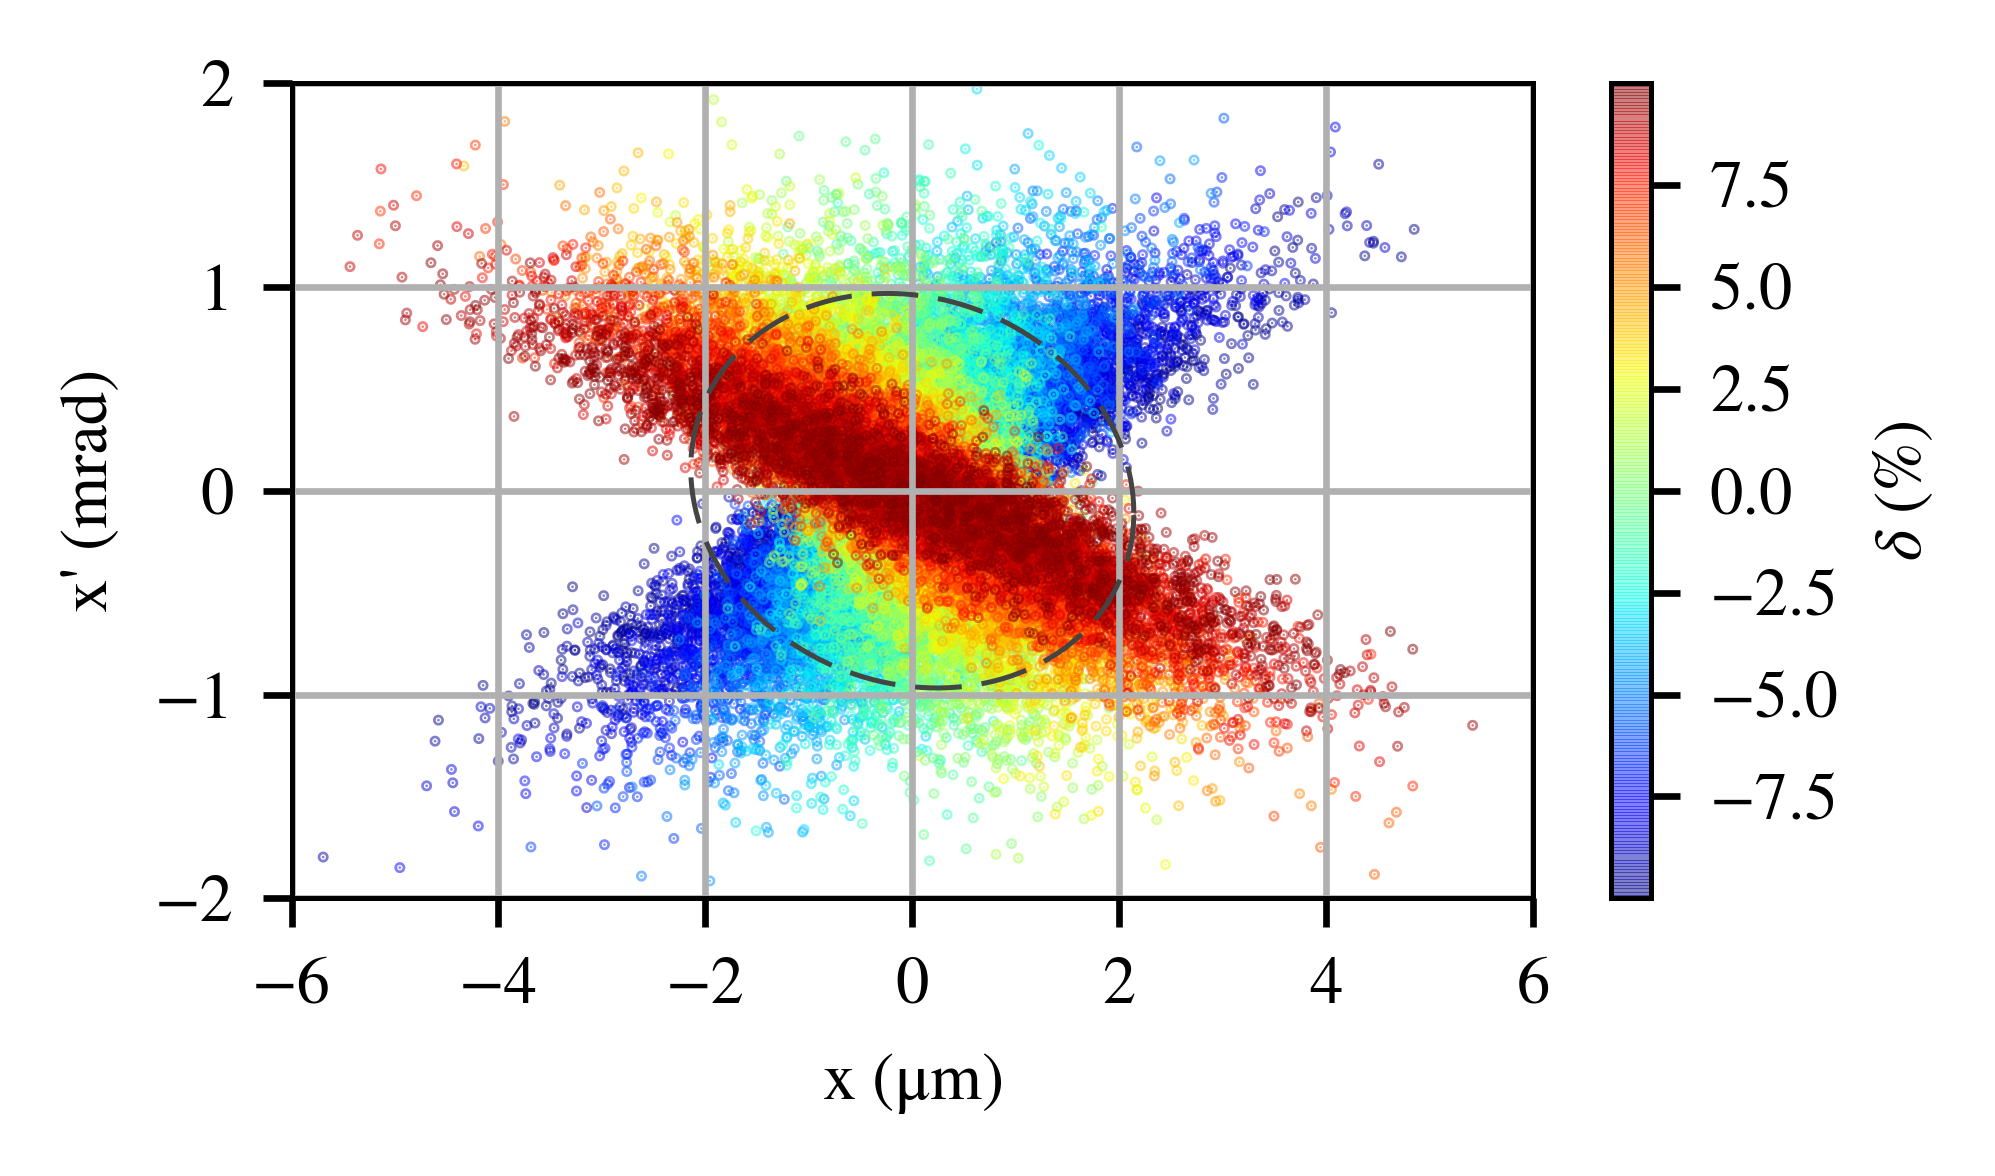

In [15]:
for i in range(0, Nz):
    ptcls = beam.load_ptcls(i)[0]

ind = 200
# Grab the dump we are interested in
def get_data(ind):
    ptcls, z = beam.load_ptcls(ind)
    ptx = ptcls[:, 0]*1e6
    ptxp = ptcls[:, 1]*1e3
    gamma = ptcls[:, 5]
    sort = np.argsort(gamma)
    ptx = ptx[sort]
    ptxp = ptxp[sort]
    gamma = gamma[sort]
    delta = (gamma/20000 - 1)*100
    return ptx, ptxp, delta

def calc_em(x, xp):
    dx = x - np.average(x)
    dxp = xp - np.average(xp)
    # Calculate the RMS sizes and the correlation
    sigmax2 = np.average(dx**2)
    sigmaxp2 = np.average(dxp**2)
    sigmaxxp = np.average(dx*dxp)
    ex = np.sqrt(sigmax2*sigmaxp2 - sigmaxxp**2)
    beta = sigmax2/ex
    alpha = -sigmaxxp/ex
    return beta, alpha, ex
    
# Get the first piece of data
ptx, ptxp, gamma = get_data(ind)
beta, alpha, ex = calc_em(ptx, ptxp)

# Create the emittance ellipse plot
t = np.linspace(0, 2*np.pi, 300)

# Create the plot
fig = plt.figure(figsize=(3.37, 2), dpi=600)
sct = plt.scatter(ptx, ptxp, c=gamma, cmap=plt.cm.get_cmap('jet'), 
                      alpha=0.5, marker='o', s=0.1)
em = plt.plot(2*np.sqrt(beta*ex)*np.cos(t), 2*np.sqrt(ex/beta)*(-alpha*np.cos(t)+np.sin(t)), 'k--', c=grey)[0]

# Formatting stuff
cb = plt.colorbar()
cb.set_label(r'$\delta$ (%)')
plt.xlabel(r'x ($\mathrm{\mu m}$)')
plt.ylabel(r"x' (mrad)")
plt.xlim(-6, 6)
plt.ylim(-2, 2)
plt.grid(True)
plt.tight_layout()
plt.savefig(folder+'Chromatic_Emittance.eps')
plt.savefig(folder+'Chromatic_Emittance.png')
plt.show()